In [18]:
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline
import matplotlib
import contextily as cx
import math
import numpy as np
import pandas as pd

## Visualizing results of WRF-driven AutoBEM
### And comparing it to NASA POWER (NP) driven AutoBEM

The outline of this notebook gets the building-specific data and stores it in `gdf`
After some elementary visualization of it, it is aggregated to the wrf cells and stored in `cells_gdf`
The geometry on each of these is the same (the centroid of the wrf cell), but `cells_gdf` is just aggregated while `gdf` is not (`gdf` has roughly 1.5 million rows)

Some key findings are presented below, namely an urban-rural split between WRF and NP for many variables. Most variables are somewhat normally distributed around 0% change, but this split is seen when plotted on a map. The surface outside heat emission and anthropogenic emission variables are both drastically lower, however, normally distributed around -20%.

This urban-rural split may be caused by not just urban heat island etc, but higher number of buildings per grid cell the closer you get to central phoenix, so changes in energy usage are more pronounced.

In [19]:
# read in all building results and define what Phoenix metro is
gdf = gpd.read_file('./buildings_results', use_arrow=True)
from shapely.geometry import Polygon
bounds = Polygon([(-113, 34),(-113, 32.8),(-111.2, 32.8),(-111.2, 34)])

In [54]:
# define a rudimentary percent change
def percent_change(col1,col2):
        return ((col2 - col1) / col1) * 100


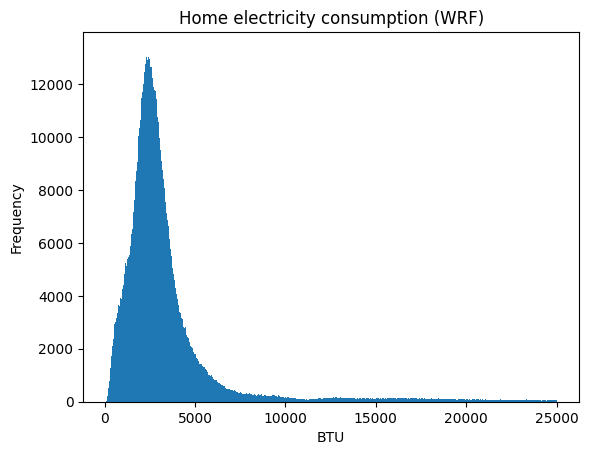

6832.885233783862


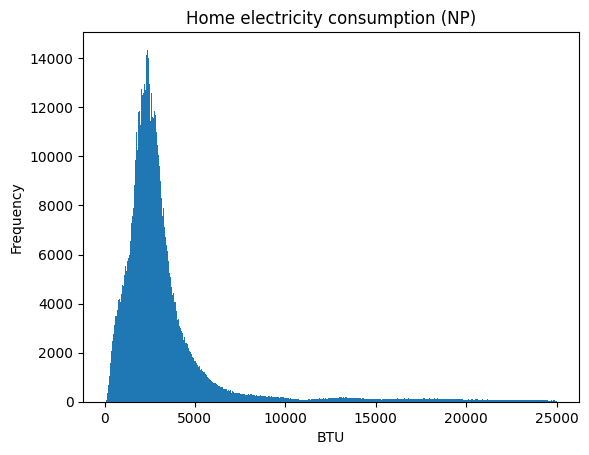

6794.418681582761


In [66]:
# plot home electricity consumption from wrf and from np just to show what kind of data we're dealing with
ax = gdf[gdf['Electricit'] < 25000]['Electricit'].plot.hist(bins=int(np.sqrt(len(gdf.index))-200))
ax.set_title('Home electricity consumption (WRF)')
ax.set_xlabel('BTU')
plt.show()
print(gdf['Electricit'].mean())
ax = gdf[gdf['Electric_1'] < 25000]['Electric_1'].plot.hist(bins=int(np.sqrt(len(gdf.index))-200))
ax.set_title('Home electricity consumption (NP)')
ax.set_xlabel('BTU')
plt.show()
print(gdf['Electric_1'].mean())

In [22]:
# aggregate into grid cells
foo = gdf.groupby('geometry').sum().reset_index()
cells_gdf = gpd.GeoDataFrame(foo, geometry=foo['geometry'])

16535
20669


<Axes: >

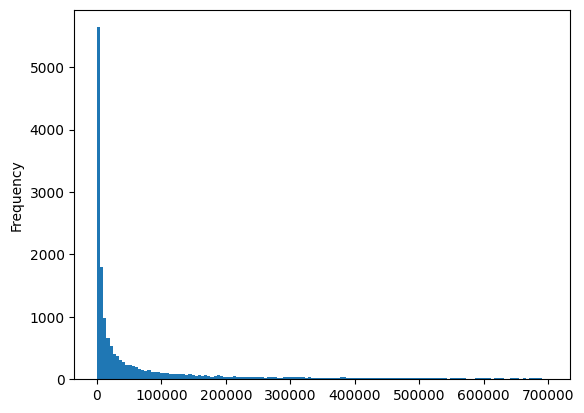

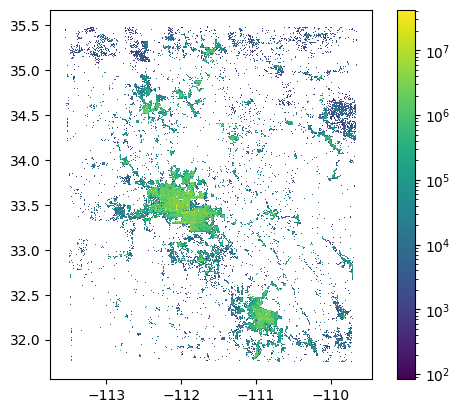

In [23]:
cells_gdf[cells_gdf['Electricit'] < 700000]['Electricit'].plot.hist(bins=int(np.sqrt(len(cells_gdf.index))))
print((cells_gdf['Electricit'] < 700000).sum())
print((cells_gdf['Electricit'] > 0).sum())

cells_gdf.plot(column='Electricit', legend=True, norm=matplotlib.colors.LogNorm(vmin=cells_gdf['Electricit'].min(), vmax=cells_gdf['Electricit'].max()))

(cells_gdf[f'{key}_change'] > 1500).sum()=818
(cells_gdf[f'{key}_change'] < -1500).sum()=0


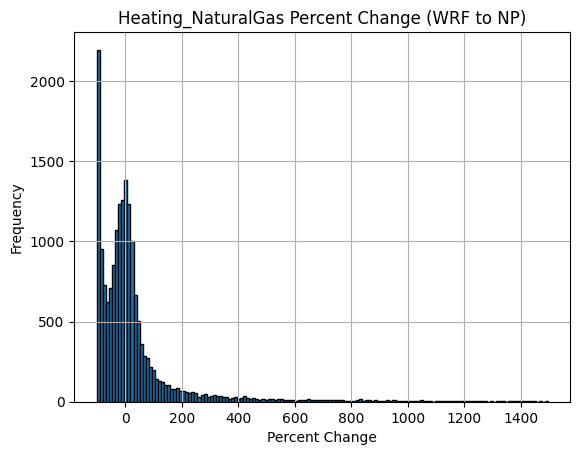

(cells_gdf[f'{key}_change'] > 1500).sum()=0
(cells_gdf[f'{key}_change'] < -1500).sum()=0


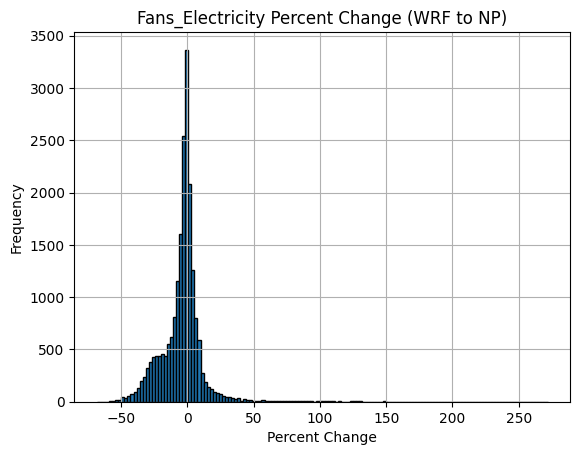

(cells_gdf[f'{key}_change'] > 1500).sum()=0
(cells_gdf[f'{key}_change'] < -1500).sum()=0


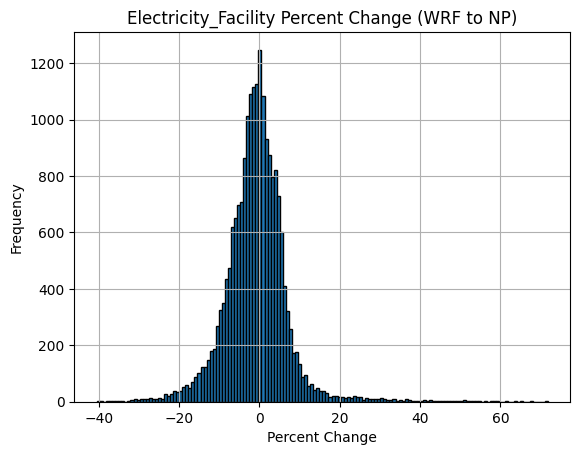

(cells_gdf[f'{key}_change'] > 1500).sum()=0
(cells_gdf[f'{key}_change'] < -1500).sum()=0


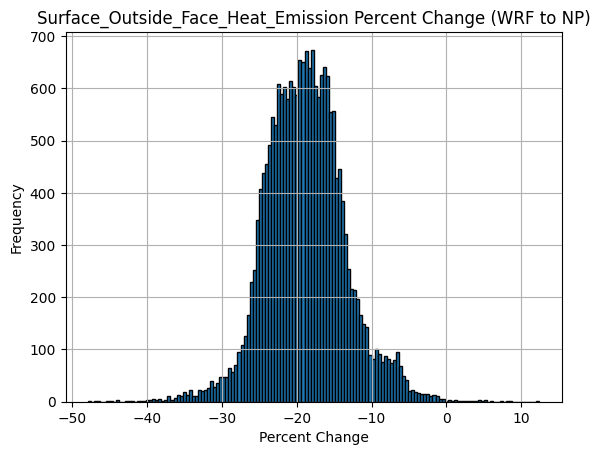

(cells_gdf[f'{key}_change'] > 1500).sum()=0
(cells_gdf[f'{key}_change'] < -1500).sum()=0


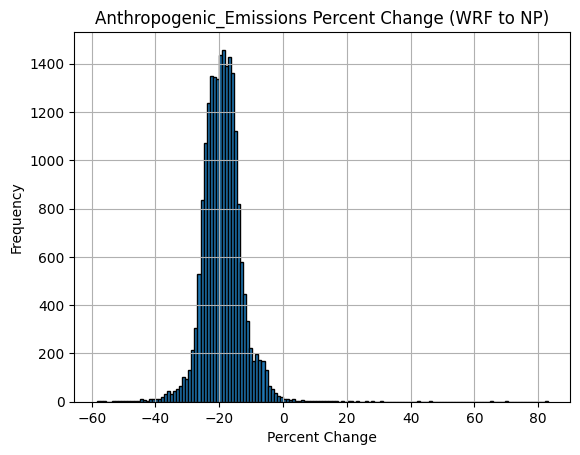

(cells_gdf[f'{key}_change'] > 1500).sum()=1
(cells_gdf[f'{key}_change'] < -1500).sum()=0


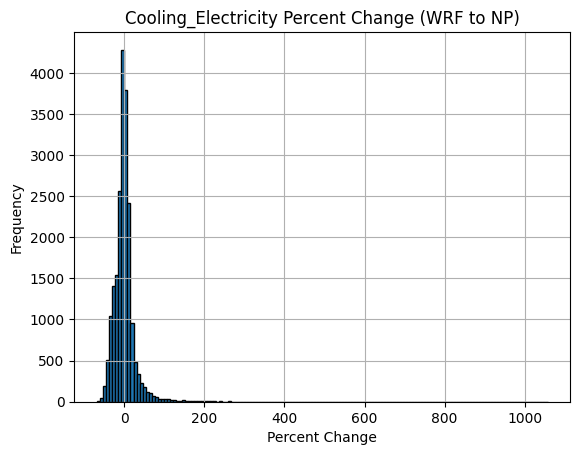

(cells_gdf[f'{key}_change'] > 1500).sum()=387
(cells_gdf[f'{key}_change'] < -1500).sum()=0


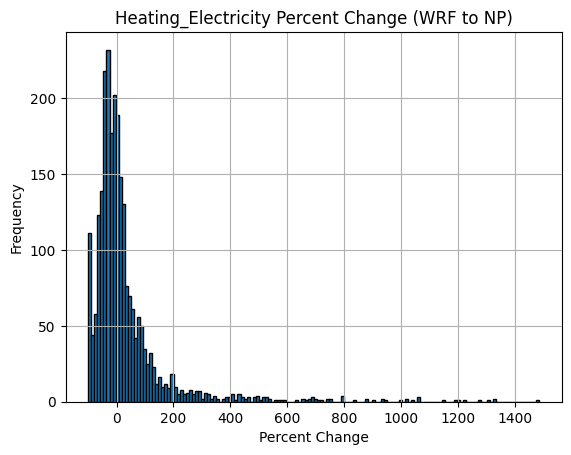

(cells_gdf[f'{key}_change'] > 1500).sum()=761
(cells_gdf[f'{key}_change'] < -1500).sum()=0


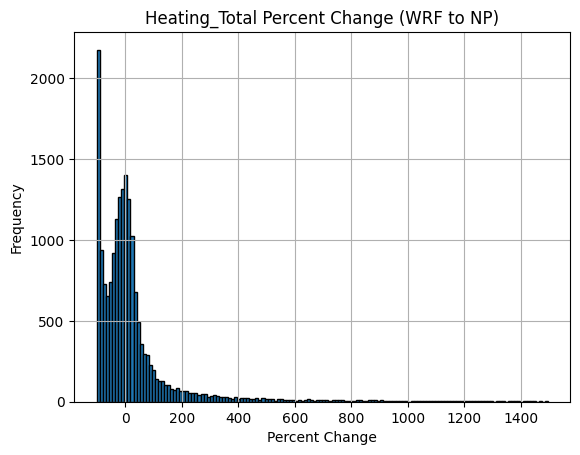

(cells_gdf[f'{key}_change'] > 1500).sum()=179
(cells_gdf[f'{key}_change'] < -1500).sum()=220


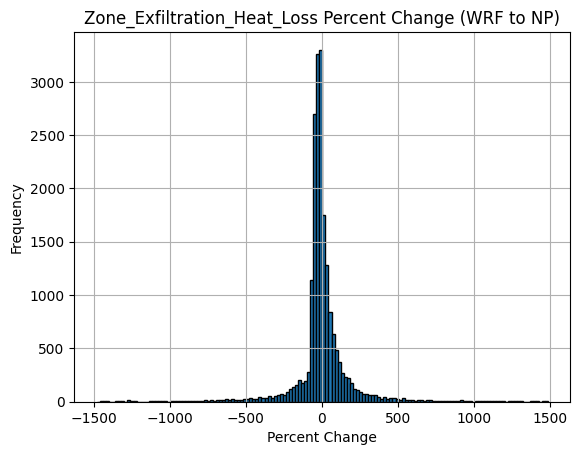

In [67]:
# plot a host of variables that have some meaning and their percent changes from WRF to NP
# many outliers are removed

cols_dict = {
    'Heating_NaturalGas': ('Heating_Na', 'Heating__2'),
    'Fans_Electricity': ('Fans_Elect', 'Fans_Ele_1'),
    'Electricity_Facility': ('Electricit', 'Electric_1'),
    'Surface_Outside_Face_Heat_Emission': ('Surface_Ou', 'Surface__1'),
    'Anthropogenic_Emissions': ('Anthropoge', 'Anthropo_1'),
    'Cooling_Electricity': ('Cooling_El', 'Cooling__1'),
    'Heating_Electricity': ('Heating_El', 'Heating__1'),
    'Heating_Total': ('Heating_To', 'Heating__3'),
    'Zone_Exfiltration_Heat_Loss': ('Zone_Exfil', 'Zone_Exf_1'),
}

for key, val in cols_dict.items():
    cells_gdf[f'{key}_change'] = percent_change(cells_gdf[val[0]], cells_gdf[val[1]])
    print(f"{(cells_gdf[f'{key}_change'] > 1500).sum()=}")
    print(f"{(cells_gdf[f'{key}_change'] < -1500).sum()=}")
    # [(cells_gdf[f'{key}_change'] < 100) & (cells_gdf[f'{key}_change'] > -100)]
    ax = cells_gdf[(cells_gdf[f'{key}_change'] < 1500) & (cells_gdf[f'{key}_change'] > -1500)][f'{key}_change'].replace([np.inf, -np.inf], np.nan).dropna().plot.hist(edgecolor='black',
                                                                                                      bins=math.floor(
                                                                                                          math.sqrt(
                                                                                                              len(cells_gdf.index))) + 5)
    ax.set_title(f'{key} Percent Change (WRF to NP)')
    ax.set_xlabel('Percent Change')
    ax.grid()
    plt.show()



### Rural vs urban split

Here we can see the rural vs urban split in many variables and their percent changes. If WRF is the "more accurate" weather, then we can view this as how NP discrepancies differ along different variables, ie a negative value means that NP is lower than real and positive means it is higher than real.

* Heating natural gas: NP overestimates urban, underestimates rural
* Fan electricity: NP underestimates urban, overestimates rural
* Total electricity: NP underestimates urban, overestimates rural
* Surface outside heat emission: NP underestimates both urban and rural
* Anthropogenic emission: NP underestimates both urban and rural
* Cooling electricity: NP underestimates urban, overestimates rural
* Heating total: NP overestimates urban, underestimates rural


Note: since one or two variables have relatively small values, percent changes may be exaggerated

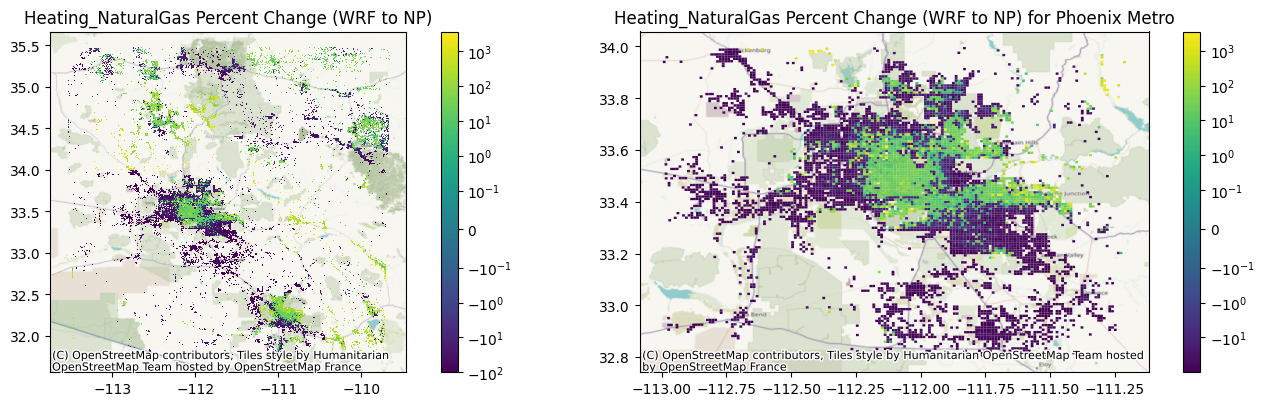

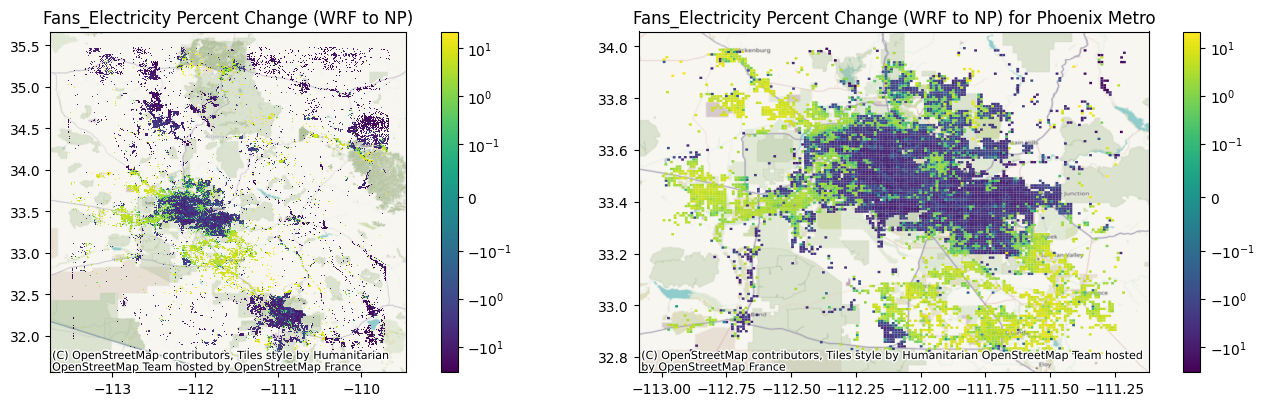

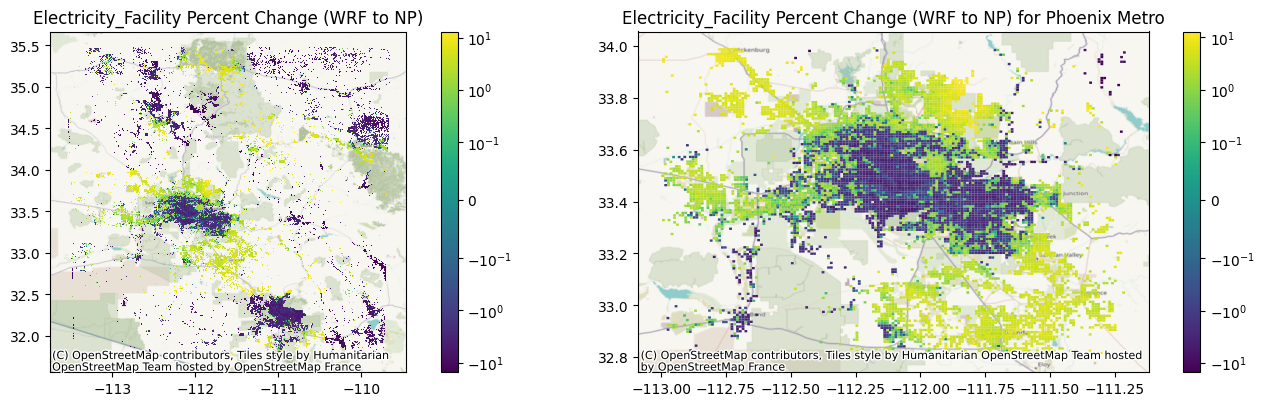

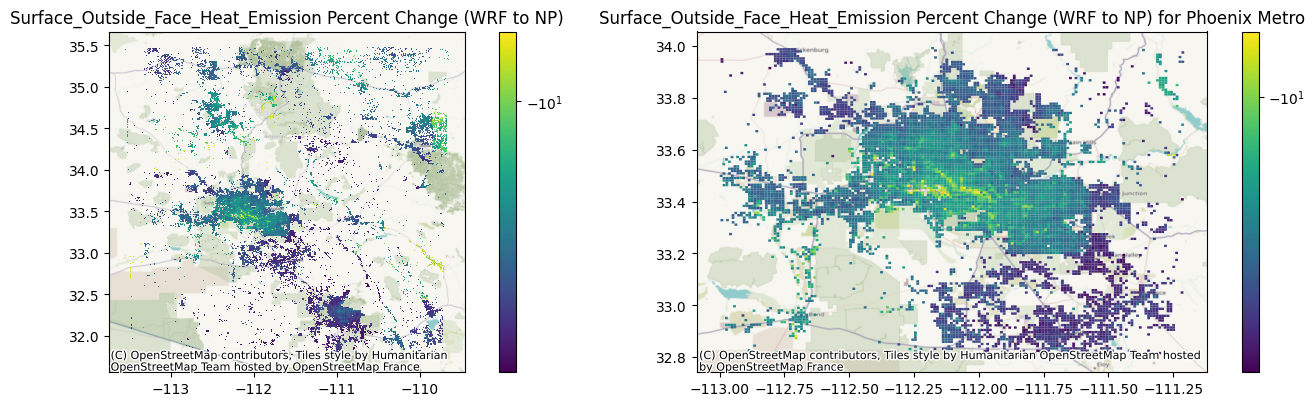

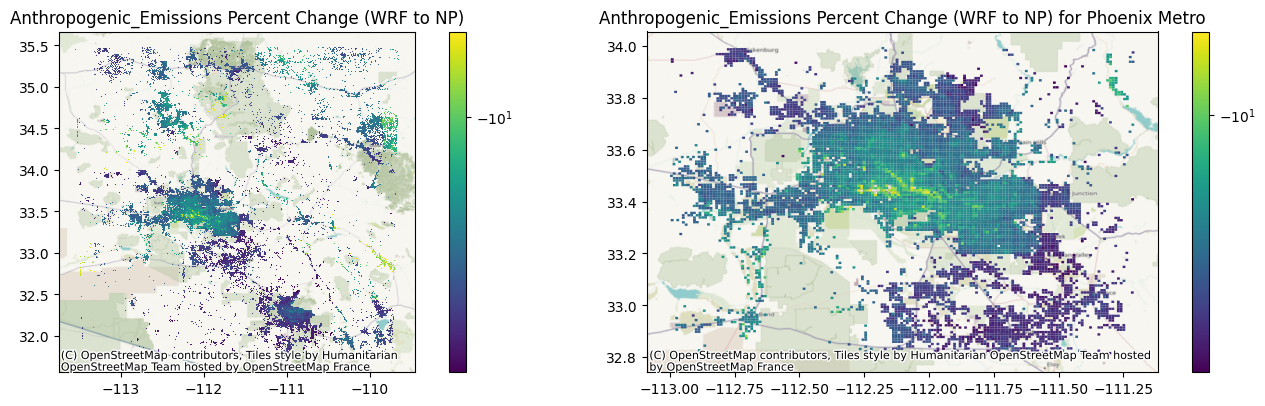

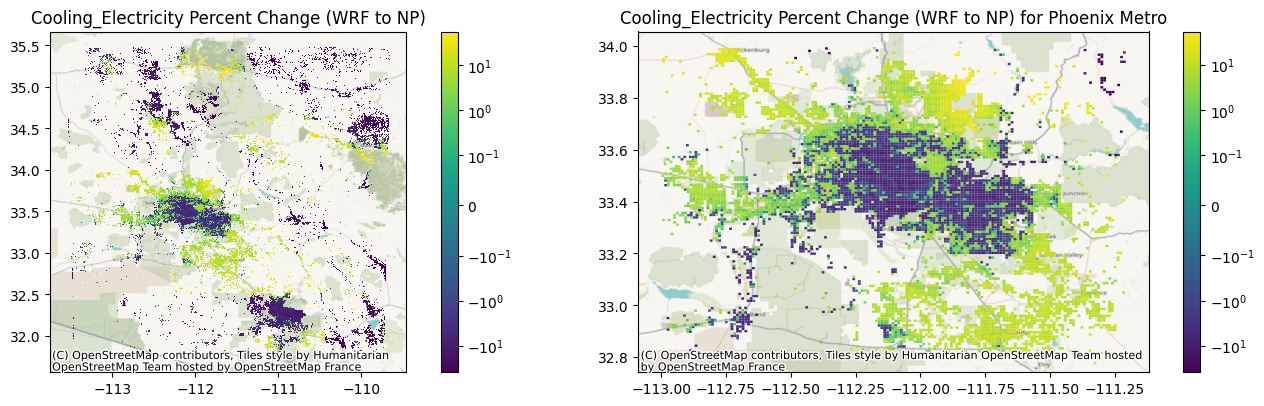

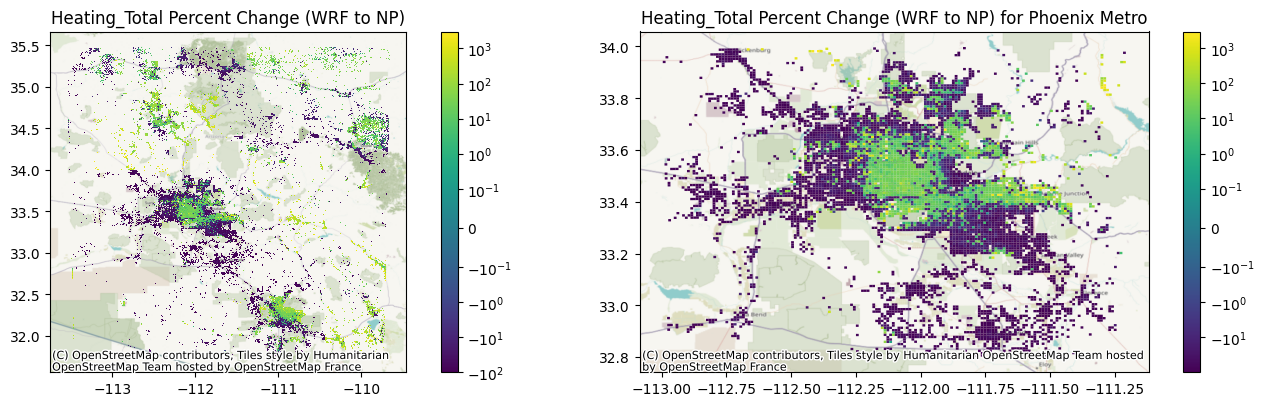

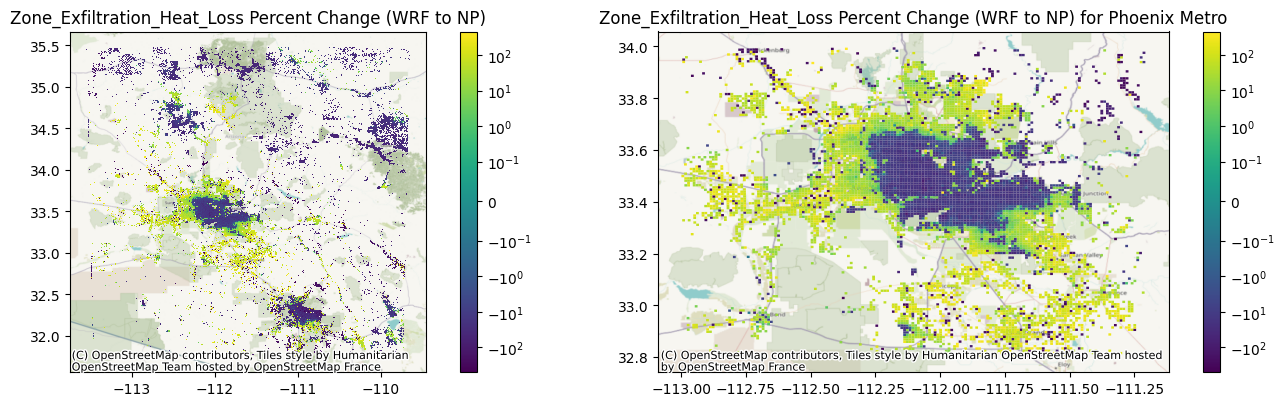

In [81]:
cols_dict = {  # get rid of heating electricity. too many zeroes for percentages to play nice. maybe we can do totals later todo
    'Heating_NaturalGas': ('Heating_Na', 'Heating__2'),
    'Fans_Electricity': ('Fans_Elect', 'Fans_Ele_1'),
    'Electricity_Facility': ('Electricit', 'Electric_1'),
    'Surface_Outside_Face_Heat_Emission': ('Surface_Ou', 'Surface__1'),
    'Anthropogenic_Emissions': ('Anthropoge', 'Anthropo_1'),
    'Cooling_Electricity': ('Cooling_El', 'Cooling__1'),
    'Heating_Total': ('Heating_To', 'Heating__3'),
    'Zone_Exfiltration_Heat_Loss': ('Zone_Exfil', 'Zone_Exf_1'),
}

for key, val in list(cols_dict.items()):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 4))
    fig.tight_layout()
    series = cells_gdf[f'{key}_change']
    lower_quantile = series.quantile(q=.03, interpolation='higher')
    upper_quantile = series.quantile(q=.97, interpolation='lower')
    cells_gdf[(series > lower_quantile) & (series < upper_quantile)].plot(column=f'{key}_change', ax=ax1, legend=True, norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=lower_quantile, vmax=upper_quantile))
    ax1.set_title(f'{key} Percent Change (WRF to NP)')
    cx.add_basemap(ax1, crs="epsg:4326")
    
    phx_tmp = cells_gdf[(cells_gdf.within(bounds)) & (series > lower_quantile) & (series < upper_quantile)]
    phx_tmp.plot(column=f'{key}_change', ax=ax2, legend=True, norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=phx_tmp[f'{key}_change'].min(), vmax=phx_tmp[f'{key}_change'].max()))
    ax2.set_title(f'{key} Percent Change (WRF to NP) for Phoenix Metro')
    cx.add_basemap(ax2, crs="epsg:4326")

    plt.show()


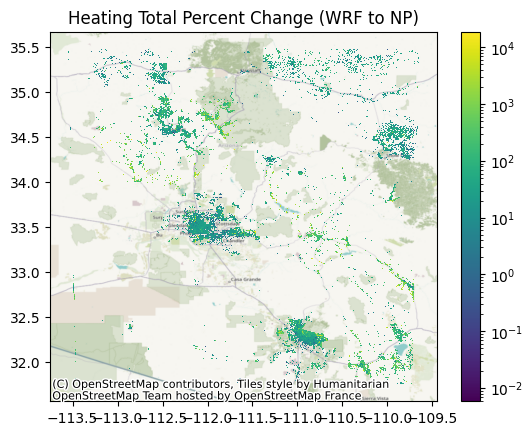

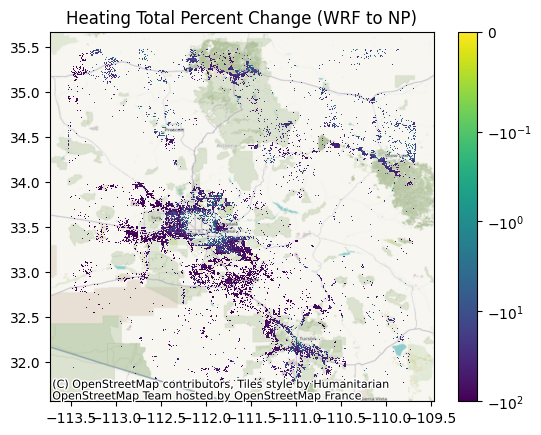

In [25]:
# an elementary map of heating total change percent that is positive and negative
# shows more clearly the distribution against phoenix itself

bar = cells_gdf['Heating_Total_change'].replace([np.inf, -np.inf], np.nan).dropna()

foo = bar[(bar > 0) & (bar < 20_000)]
ax = cells_gdf[(cells_gdf['Heating_Total_change'] > 0) & (cells_gdf['Heating_Total_change'] < 15_000)].plot(column='Heating_Total_change', legend=True, norm=matplotlib.colors.LogNorm(vmin=foo.min(), vmax=foo.max()))
cx.add_basemap(ax, crs="epsg:4326")
ax.set_title('Heating Total Percent Change (WRF to NP)')
plt.show()

foo = bar[(bar < 0)]
ax = cells_gdf[(cells_gdf['Heating_Total_change'] < 0)].plot(column='Heating_Total_change', legend=True, norm=matplotlib.colors.SymLogNorm(linthresh=.1, vmin=foo.min(), vmax=0))
ax.set_title('Heating Total Percent Change (WRF to NP)')
cx.add_basemap(ax, crs="epsg:4326")
plt.show()

In [ ]:
# now i want to compare wrf to np. see what we actually really changed in terms of inputs to energyplus
